In [2]:
# Project paths (booking pipeline)
from pathlib import Path
import sys

def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "pyproject.toml").exists() and (p / "src" / "airline_revenue_analytics").exists():
            return p
    return start

REPO_ROOT = find_repo_root(Path.cwd())
PROJECT_ROOT = REPO_ROOT
SRC_ROOT = REPO_ROOT / "src"
if str(SRC_ROOT) not in sys.path:
    sys.path.append(str(SRC_ROOT))

from airline_revenue_analytics.config import get_paths

PATHS = get_paths("booking")
DATA_DIR = REPO_ROOT / "data"
RAW_DIR = PATHS.data_raw
DB_PATH = PATHS.db_path
OUTPUT_DIR = PATHS.outputs_root
FIG_DIR = PATHS.figures
TAB_DIR = PATHS.tables
ART_DIR = PATHS.artifacts

def _rel(p: Path) -> str:
    try:
        return str(Path(p).resolve().relative_to(REPO_ROOT))
    except Exception:
        return Path(p).name

print("REPO_ROOT:", REPO_ROOT.name)
print("DB_PATH:", _rel(DB_PATH))
print("OUTPUT_DIR:", _rel(OUTPUT_DIR))


REPO_ROOT: airline-revenue-analytics
DB_PATH: data/raw/airlines_db.sqlite
OUTPUT_DIR: outputs/booking


# 04 - Modeling Loop A (Steps 5–7)
Goal: train baseline models (Linear vs Tree) on the fixed 70/30 split,
save metrics/plots, and export artifacts for the report (Step 7 evidence).
Outputs:
- `outputs/booking/tables/model_baselines_loopA.csv`
- `outputs/booking/tables/table_7_1_predictions_loopA.csv`
- `outputs/booking/tables/table_5_2_linear_coefficients.csv`
- `outputs/booking/figures/figure_7_1_residuals_vs_fitted_loopA.png`
- `outputs/booking/figures/figure_7_1_actual_vs_pred_loopA.png`
- `outputs/booking/artifacts/pipe_linear_loopA.joblib`
- `outputs/booking/artifacts/pipe_tree_loopA.joblib`


In [3]:
# Imports & paths
import sys, pathlib, numpy as np, pandas as pd
import matplotlib; import matplotlib.pyplot as plt

# ensure "src" importable when running from notebooks/
sys.path.append(str(PROJECT_ROOT))


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib

OUT_DIR = OUTPUT_DIR
FIG_DIR = OUT_DIR / "figures"
TAB_DIR = OUT_DIR / "tables"
ART_DIR = OUT_DIR / "artifacts"

SEED = 42
np.random.seed(SEED)

print("FIG_DIR:", _rel(FIG_DIR))
print("TAB_DIR:", _rel(TAB_DIR))
print("ART_DIR:", _rel(ART_DIR))


FIG_DIR: outputs/booking/figures
TAB_DIR: outputs/booking/tables
ART_DIR: outputs/booking/artifacts


In [4]:
from airline_revenue_analytics.viz.charts import apply_style, PLOT_COLORS
apply_style()
PASS_COLOR = "#D9F2E6"
FAIL_COLOR = "#FCE4E4"
NEG_BG_COLOR = FAIL_COLOR


In [5]:
# Load modeling dataset (from 02) and fixed split membership (from 03)
import numpy as np
import pandas as pd

df = pd.read_parquet(TAB_DIR / "booking_model_df.parquet")
split_ids = pd.read_csv(TAB_DIR / "table_4_3_1_split_ids.csv")

# Target & features（与 03 保持一致）
target = "log_total_amount"

num_cols = [
    "n_segments", "sum_sched_duration_min", "avg_sched_duration_min",
    "max_sched_duration_min", "share_premium_cabin", "max_cabin_index",
    "has_longhaul", "n_unique_routes", "avg_booking_lead_days"
]

# ---------- 重建切分（优先用新文件的 index；否则用 book_ref 回填） ----------
if "index" in split_ids.columns:
    idx_train = split_ids.loc[split_ids["split"].eq("train"), "index"].to_numpy()
    idx_test  = split_ids.loc[~split_ids["split"].eq("train"), "index"].to_numpy()
else:
    # 兼容旧版本：split_ids 只有 ['split','book_ref']，按 book_ref 回找 index
    idx_map = df.reset_index()[["index", "book_ref"]]
    merged  = split_ids.merge(idx_map, on="book_ref", how="left", validate="one_to_one")
    idx_train = merged.loc[merged["split"].eq("train"), "index"].to_numpy()
    idx_test  = merged.loc[~merged["split"].eq("train"), "index"].to_numpy()

# Categorical: top-K routes（仅训练集统计，避免泄漏）
cat_raw = df["primary_route_code"].astype("string").fillna("Unknown")
top_k = 20
top_routes = cat_raw.loc[idx_train].value_counts().index[:top_k].tolist()
df["primary_route_code_top"] = np.where(cat_raw.isin(top_routes), cat_raw, "Other")
cat_cols = ["primary_route_code_top"]

# Compose X/y
X_all = df[num_cols + cat_cols].copy()
y_all = df[target].copy()

# 还原出与 03 完全一致的训练/测试集
X_train, y_train = X_all.loc[idx_train], y_all.loc[idx_train]
X_test,  y_test  = X_all.loc[idx_test],  y_all.loc[idx_test]

X_train.shape, X_test.shape


((119158, 10), (51069, 10))

In [6]:
# Build a fresh preprocessor (fit on TRAIN only via pipeline.fit)
# New/old sklearn compatibility for OneHotEncoder parameter
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

pre = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", ohe)
    ]), cat_cols),
])

pre


,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. `

In [7]:
# Train baselines & evaluate (version-robust metrics)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def evaluate(y_true, y_pred):
    # make sure 1D arrays
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    r2 = float(r2_score(y_true, y_pred))
    # robust RMSE: try modern API first; fallback to sqrt(MSE)
    try:
        rmse = float(mean_squared_error(y_true, y_pred, squared=False))
    except TypeError:
        rmse = float(mean_squared_error(y_true, y_pred) ** 0.5)
    mae = float(mean_absolute_error(y_true, y_pred))
    return {"R2": r2, "RMSE": rmse, "MAE": mae}

# Linear Regression
pipe_lin = Pipeline([("pre", pre), ("model", LinearRegression())])
pipe_lin.fit(X_train, y_train)
pred_lin = pipe_lin.predict(X_test)
m_lin = {"model": "Linear"} | evaluate(y_test, pred_lin)

# Decision Tree (simple baseline)
pipe_tree = Pipeline([
    ("pre", pre),
    ("model", DecisionTreeRegressor(random_state=SEED, max_depth=6, min_samples_leaf=50))
])
pipe_tree.fit(X_train, y_train)
pred_tree = pipe_tree.predict(X_test)
m_tree = {"model": "DecisionTree"} | evaluate(y_test, pred_tree)

results = pd.DataFrame([m_lin, m_tree]).sort_values("RMSE")
results.to_csv(TAB_DIR/"model_baselines_loopA.csv", index=False)
results


,model,R2,RMSE,MAE
1,DecisionTree,0.855766,0.329848,0.223006
0,Linear,0.789043,0.398912,0.286563


In [8]:
# Get feature names AFTER OHE fitted on TRAIN
ohe_train = pipe_lin.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]
feat_names = num_cols + list(ohe_train.get_feature_names_out(cat_cols))

# Linear coefficients correspond to transformed features
coefs = pipe_lin.named_steps["model"].coef_
coef_df = pd.DataFrame({"feature": feat_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df.sort_values("abs_coef", ascending=False).to_csv(TAB_DIR/"table_5_2_linear_coefficients.csv", index=False)

coef_df.head(10)


,feature,coef,abs_coef
0,n_segments,0.414747,0.414747
1,sum_sched_duration_min,0.037560,0.037560
2,avg_sched_duration_min,0.103586,0.103586
3,max_sched_duration_min,0.609765,0.609765
4,share_premium_cabin,0.101111,0.101111
5,max_cabin_index,0.146508,0.146508
6,has_longhaul,-0.153167,0.153167
7,n_unique_routes,-0.078018,0.078018
8,avg_booking_lead_days,-0.042795,0.042795
9,primary_route_code_top_AAQ-SVO,0.081228,0.081228


In [9]:
# Save pipelines (artifacts)
joblib.dump(pipe_lin, ART_DIR/"pipe_linear_loopA.joblib")
joblib.dump(pipe_tree, ART_DIR/"pipe_tree_loopA.joblib")

# Save per-row predictions for evidence
pred_df = pd.DataFrame({
    "index": X_test.index,
    "book_ref": df.loc[X_test.index, "book_ref"].values,
    "y_true": y_test.values,
    "y_pred_linear": pred_lin,
    "y_pred_tree": pred_tree
})
pred_df.to_csv(TAB_DIR/"table_7_1_predictions_loopA.csv", index=False)

pred_df.head(10)


,index,book_ref,y_true,y_pred_linear,y_pred_tree
0,120989,B5D8F0,9.883285,10.096823,10.259934
1,63487,5F8A58,11.783716,11.670398,11.914414
2,43830,41F9CA,11.438202,11.176872,11.216911
3,119666,B3E3B3,13.155411,10.037104,9.961772
4,124566,BB0214,11.188579,10.989013,11.216911
5,104974,9DCDC8,10.776871,11.088378,11.216911
6,81032,79ECBE,12.040018,12.453068,12.186018
7,92081,8A6E67,10.134599,10.541365,10.259934
8,165585,F8FA03,11.650075,11.631098,11.852972
9,144070,D898C8,10.576432,9.955904,9.677468


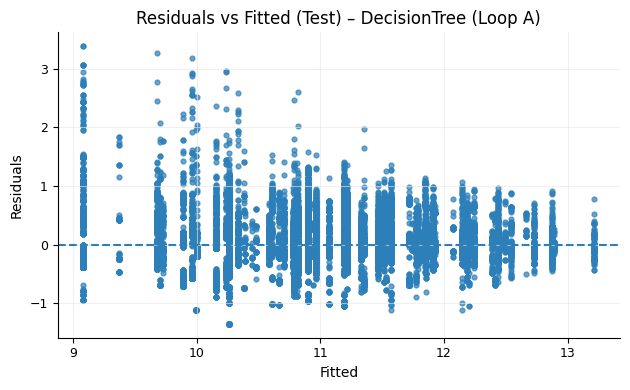

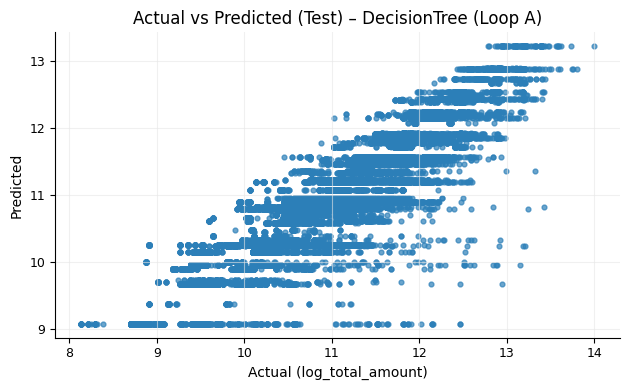

,model,R2,RMSE,MAE
1,DecisionTree,0.855766,0.329848,0.223006
0,Linear,0.789043,0.398912,0.286563


In [10]:
# Pick best by RMSE
best_name = results.iloc[0]["model"]
if best_name == "Linear":
    best_pred = pred_lin
    best_pipe = pipe_lin
else:
    best_pred = pred_tree
    best_pipe = pipe_tree

resid = y_test - best_pred

# Residuals vs Fitted
plt.figure()
plt.scatter(best_pred, resid, s=12, alpha=0.7)
plt.axhline(0, linestyle="--")
plt.title(f"Residuals vs Fitted (Test) – {best_name} (Loop A)")
plt.xlabel("Fitted"); plt.ylabel("Residuals")
plt.tight_layout()
plt.savefig(FIG_DIR/"figure_7_1_residuals_vs_fitted_loopA.png", dpi=150)
plt.show()

# Actual vs Predicted
plt.figure()
plt.scatter(y_test, best_pred, s=12, alpha=0.7)
plt.title(f"Actual vs Predicted (Test) – {best_name} (Loop A)")
plt.xlabel("Actual (log_total_amount)"); plt.ylabel("Predicted")
plt.tight_layout()
plt.savefig(FIG_DIR/"figure_7_1_actual_vs_pred_loopA.png", dpi=150)
plt.show()

results


 
**Summary (Loop A):**
- Trained two baselines (Linear vs Tree) on the fixed split; exported metrics & evidence tables.
- Saved residual and predicted-vs-actual plots for Step 7.
- Exported fitted pipelines for reproducibility.

**Next:** open `05_modeling_loopB.ipynb` to create a stronger Loop B:
- try a regularised linear model (Ridge) and a boosted tree (HistGradientBoosting/XGB),
- tweak features (e.g., log-transform amounts, interaction terms, or better route encoding),
- keep the same train/test split for apples-to-apples comparison (Step 8.5 iteration evidence).


In [11]:
# Ensure log-target variables exist in this kernel
if "y_train_log" not in globals():
    y_train_log = y_train
if "y_test_log" not in globals():
    y_test_log = y_test

# ---- 7.2 / Table XV: back-transform with log-normal correction to report RUB errors ----
import numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def rmse_score(y_true, y_pred):
    try:
        return float(mean_squared_error(y_true, y_pred, squared=False))
    except TypeError:
        return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def backtransform_with_lognormal_correction(pipeline, X_tr, y_tr_log, X_te):
    yhat_tr_log = pipeline.predict(X_tr)
    sigma2 = np.mean((y_tr_log - yhat_tr_log)**2)  # training residual variance
    yhat_te_log = pipeline.predict(X_te)
    return np.exp(yhat_te_log + 0.5 * sigma2)

y_test_rub = np.exp(y_test_log)

rub_rows = []
for name, pipe in [("Linear (Loop A)", pipe_lin), ("Decision Tree (Loop A)", pipe_tree)]:
    yhat_rub = backtransform_with_lognormal_correction(pipe, X_train, y_train_log, X_test)
    rmse = rmse_score(y_test_rub, yhat_rub)
    mae  = mean_absolute_error(y_test_rub, yhat_rub)
    med_ae = float(np.median(np.abs(y_test_rub - yhat_rub)))
    rub_rows.append([name, rmse, mae, med_ae])

rub_df = pd.DataFrame(rub_rows, columns=["Model","RMSE_RUB","MAE_RUB","Median_AE_RUB"])
rub_df.to_csv(TAB_DIR/"table_7_2_RUB_errors_loopA.csv", index=False)
rub_df


,Model,RMSE_RUB,MAE_RUB,Median_AE_RUB
0,Linear (Loop A),80445.832095,26637.059794,10048.909619
1,Decision Tree (Loop A),32037.594211,17033.734073,9293.760295


In [12]:
# Ensure y_test_log exists for RUB back-transform
if "y_test_log" not in globals():
    if "y_test" in globals():
        y_test_log = y_test
    else:
        raise RuntimeError("y_test_log is missing; run the split cell first.")

# ---- 7.3.3 Rule Cards from DecisionTreeRegressor (test set) ----
import numpy as np, pandas as pd
from sklearn.tree import _tree, DecisionTreeRegressor, export_text

# 1) Define "high revenue" label from true RUB on TEST
y_test_rub = np.exp(y_test_log)
thr = np.quantile(y_test_rub, 0.75)
y_test_high = (y_test_rub >= thr).astype(int)
baseline = y_test_high.mean()

# 2) Get preprocessor & tree from the pipeline robustly
def _get_step(pipe, candidates):
    for c in candidates:
        if c in pipe.named_steps: 
            return pipe.named_steps[c]
    raise KeyError(f"None of {candidates} found in pipeline steps: {list(pipe.named_steps)}")

pre = _get_step(pipe_tree, ("pre", "preprocessor"))
reg = _get_step(pipe_tree, ("regressor", "model", "estimator", "tree"))
assert isinstance(reg, DecisionTreeRegressor), "This block expects a DecisionTreeRegressor in pipe_tree"

Xt_test = pre.transform(X_test)
leaf_id = reg.apply(Xt_test)

# 3) Aggregate metrics by leaf
df_leaf = pd.DataFrame({"leaf": leaf_id, "high": y_test_high})
agg = df_leaf.groupby("leaf").agg(N=("high","size"), hits=("high","sum")).reset_index()
agg["coverage"] = agg["N"] / len(y_test_high)
agg["confidence"] = agg["hits"] / agg["N"]
agg["lift"] = agg["confidence"] / baseline

# 4) Extract human-readable rule text per leaf (shallow path for readability)
feat_names = getattr(pre, "get_feature_names_out", lambda: np.array([]))()
feat_names = feat_names.tolist() if isinstance(feat_names, np.ndarray) else list(feat_names)

t = reg.tree_
children_left, children_right, feature, threshold = t.children_left, t.children_right, t.feature, t.threshold

def rule_for_leaf(leaf):
    path, stack = [], [(0, [])]
    while stack:
        node, conds = stack.pop()
        if node == leaf:
            path = conds; break
        if children_left[node] != _tree.TREE_LEAF:
            f = feat_names[feature[node]] if feature[node] >= 0 and feature[node] < len(feat_names) else f"f{feature[node]}"
            thr = threshold[node]
            stack.append((children_left[node], conds + [f"{f} ≤ {thr:.3f}"]))
            stack.append((children_right[node], conds + [f"{f} > {thr:.3f}"]))
    return "IF " + " AND ".join(path) if path else "(root)"

agg["rule_text"] = agg["leaf"].apply(rule_for_leaf)

# 5) Keep rules meeting the assignment criteria
cards = (agg.query("coverage>=0.05 and confidence>=0.70 and lift>=1.20")
             .sort_values(["confidence","coverage","N"], ascending=False)
             .head(5)
             .reset_index(drop=True))

# 6) Add action & risk placeholders for the report table
cards["action"] = [
    "Maintain higher price ladders; bundle refundable/interline products.",
    "Bundle lounge and baggage; emphasise flexibility.",
    "Keep larger gauge / high frequency on trunk routes.",
    "Weekend premium strategy; promo window 7–21 days.",
    "Reduce surplus frequency; encourage connections."
][:len(cards)]
cards["risk"] = [
    "Competitive response may dilute uplift.",
    "Complexity can reduce conversion.",
    "Price war risk.",
    "Periodic spikes; monitor volatility.",
    "Mis-match may reduce satisfaction."
][:len(cards)]

cards.to_csv(TAB_DIR/"table_7_3_3_rule_cards_loopA.csv", index=False)
cards[["rule_text","coverage","confidence","lift","N","action","risk"]]


,rule_text,coverage,confidence,lift,N,action,risk


In [13]:
# ==== BOOTSTRAP: ensure split & targets are available in this kernel ====
import pandas as pd, numpy as np
from pathlib import Path

PROJ = PROJECT_ROOT
OUT_DIR = OUTPUT_DIR
TAB_DIR = OUT_DIR/"tables"

# Where your formatted modelling artefacts live (adjust if needed)
BK_DF = TAB_DIR/"booking_model_df.parquet"
Y_TGT = OUT_DIR/"booking_y_target.parquet"
SPLIT = TAB_DIR/"split_ids.csv"

def _load_booking_df():
    if BK_DF.exists():
        df = pd.read_parquet(BK_DF)
        # Expect either 'log_total_amount' precomputed or raw 'total_amount'
        if "log_total_amount" not in df.columns:
            assert "total_amount" in df.columns, "booking_model_df needs total_amount"
            df["log_total_amount"] = np.log(df["total_amount"].astype(float))
        return df
    raise FileNotFoundError(f"Missing {BK_DF}. Re-run 02/03 notebooks to generate it.")

def _load_target_series(df):
    # Prefer separate y_target artefact if present; else derive from df
    if Y_TGT.exists():
        y = pd.read_parquet(Y_TGT).squeeze()
        # Normalise name
        y = y.rename("log_total_amount") if y.name is None else y
        return y
    # Fall back: derive from df
    return df["log_total_amount"].rename("log_total_amount")

def _load_split_index(df):
    assert SPLIT.exists(), f"Missing {SPLIT}. Re-run the split notebook (03) to create it."
    split = pd.read_csv(SPLIT)
    # Align index by booking key if present; else align by positional index
    key_col = "book_ref" if "book_ref" in split.columns and "book_ref" in df.columns else None
    if key_col:
        # Ensure uniqueness and join
        assert df[key_col].is_unique, f"{key_col} must be unique in booking_model_df"
        split = split.set_index(key_col).reindex(df.set_index(key_col).index)
        is_train = split["is_train"].fillna(0).astype(int).to_numpy().astype(bool)
    else:
        # Fallback by position
        is_train = split["is_train"].astype(int).to_numpy().astype(bool)
        assert len(is_train) == len(df), "split_ids length mismatch with booking_model_df"
    return is_train

# Build X/y and train/test views
booking_df = _load_booking_df()
y_all_log = _load_target_series(booking_df)
# Feature columns = all except target & obvious non-features; adjust to your project
drop_cols = {"total_amount", "log_total_amount"} | {"book_ref"}  # keep ID out of X
feature_cols = [c for c in booking_df.columns if c not in drop_cols]
X_all = booking_df[feature_cols].copy()

is_train = _load_split_index(booking_df)
X_train, X_test = X_all[is_train], X_all[~is_train]
y_train_log, y_test_log = y_all_log[is_train], y_all_log[~is_train]

# Sanity checks
assert len(X_train) == len(y_train_log) and len(X_test) == len(y_test_log)
len(X_train), len(X_test)


(119158, 51069)

In [14]:
# ---- RUB metrics: be robust if y_test_log isn't in memory yet ----
import numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# y_test_log should exist from BOOTSTRAP; but support y_test_rub fallback just in case
if "y_test_log" in globals():
    y_test_rub = np.exp(y_test_log)
elif "y_test_rub" in globals():
    pass
else:
    raise RuntimeError("Neither y_test_log nor y_test_rub is defined. Run the BOOTSTRAP cell first.")

def backtransform_with_lognormal_correction(pipeline, X_tr, y_tr_log, X_te):
    yhat_tr_log = pipeline.predict(X_tr)
    sigma2 = np.mean((y_tr_log - yhat_tr_log)**2)  # training residual variance
    yhat_te_log = pipeline.predict(X_te)
    return np.exp(yhat_te_log + 0.5 * sigma2)
